In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import sys

sys.path.append('..')
from src.lippmann_schwinger_eqn.HelmholtzSolver import (
    HelmholtzSolverAccelerated,
    setup_accelerated_solver,
    setup_dense_solver,
    HelmholtzSolverDense,
)

from timeit import default_timer
import logging

# Init Helmholtz Solver

In [2]:
N_PIXELS_ARR = np.array([20, 50, 100, 192])
SPATIAL_DOMAIN_MAX = 0.5
WAVENUMBER = 16
RECIEVER_RADIUS = 100

In [3]:
solver_obj = []
for x in N_PIXELS_ARR:
    print("Working on ", x)
    solver_obj.append(setup_accelerated_solver(x, 
                                      SPATIAL_DOMAIN_MAX, 
                                      WAVENUMBER, 
                                      RECIEVER_RADIUS, 
                                      diag_correction=True))

Working on  20
Working on  50
Working on  100
Working on  192


In [4]:
print(solver_obj[0].frequency)
print(solver_obj[0].h)

100.53096491487338
0.04999999999999999


In [5]:
def relative_l2_error(preds: np.ndarray, true: np.ndarray) -> float:
    return np.linalg.norm(preds - true) / np.linalg.norm(true)

In [6]:
STENCIL = np.array([[0., 1., 0],
                   [1, -4, 1],
                   [0, 1, 0]])
def check_soln_against_finite_differences(u_soln: np.ndarray,
                                         domain_points_arr: np.ndarray,
                                         scattering_obj: np.ndarray,
                                         frequency: float) -> None:
    dx = domain_points_arr[0, 1, 0] - domain_points_arr[0, 0, 0]
    
    lap_filter = STENCIL / (dx ** 2)
    
    # Returns a slightly smaller array, which only contains those pixels which 
    # have a valid convolution output without padding
    lap_u = convolve2d(u_soln, lap_filter, mode='valid') * (dx ** 2) / (frequency ** 2)

    # Compute how many pixels I need to remove from scattering_obj and u_soln
    p = int((u_soln.shape[0] - lap_u.shape[0]) / 2)
    
    inhomogeniety =  (1 - scattering_obj[p:-p, p:-p]) * u_soln[p:-p, p:-p] * (dx ** 2)
    
    err_pointwise = lap_u + inhomogeniety
    
    # Compute the relative L2 error 
    u_soln_clipped = u_soln[p:-p, p:-p]
    rel_l2_err = np.linalg.norm(err_pointwise) / np.linalg.norm(u_soln_clipped)
    
    return err_pointwise, rel_l2_err

# Test 0: no scattering object

In [7]:
in_direction = np.array([np.pi / 4,])
err_arr_lst = []
err_val_lst_0 = []
time_lst_0 = []
for i, N_PIXELS in enumerate(N_PIXELS_ARR):
    scattering_obj_0 = np.zeros((N_PIXELS, N_PIXELS))

    t_0 = default_timer()
    soln, u_in, u_s = solver_obj[i].Helmholtz_solve_interior(in_direction, scattering_obj_0)
    time_lst_0.append(default_timer() - t_0)
    soln = soln[0]
    u_in = u_in[0]
    u_s = u_s[0]
    err_pointwise, rel_l2_err = check_soln_against_finite_differences(soln,
                                                   solver_obj[i].domain_points_arr,
                                                   scattering_obj_0,
                                                   solver_obj[i].frequency)
    
    err_arr_lst.append(err_pointwise)
    err_val_lst_0.append(rel_l2_err)
    
#     xx = check_2(u_in,
#                 u_s,
#                 solver_obj[i].domain_points_arr,
#                 scattering_obj_0,
#                 solver_obj[i].frequency)
#     check_2_arr_lst_0.append(xx)
#     check_2_val_lst_0.append(np.linalg.norm(xx))

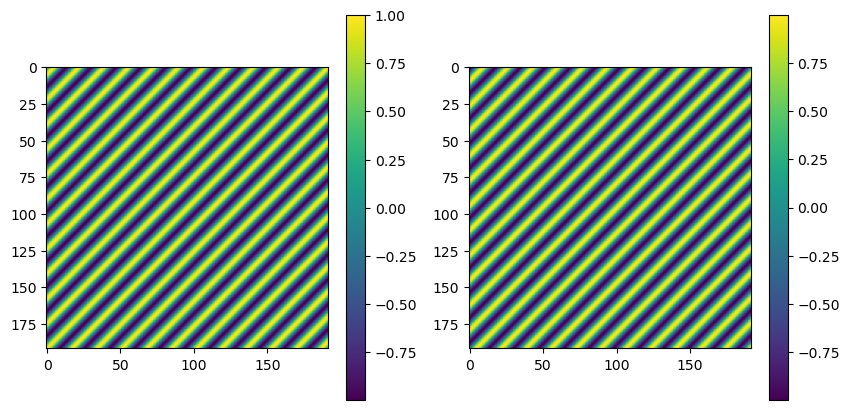

In [8]:
fig, ax = plt.subplots(1,2)
fig.patch.set_facecolor('white')
fig.set_size_inches(10, 5)
im_0 = ax[0].imshow(soln.real)
plt.colorbar(im_0, ax=ax[0])
im_1 = ax[1].imshow(soln.imag)
plt.colorbar(im_1, ax=ax[1])

plt.show()

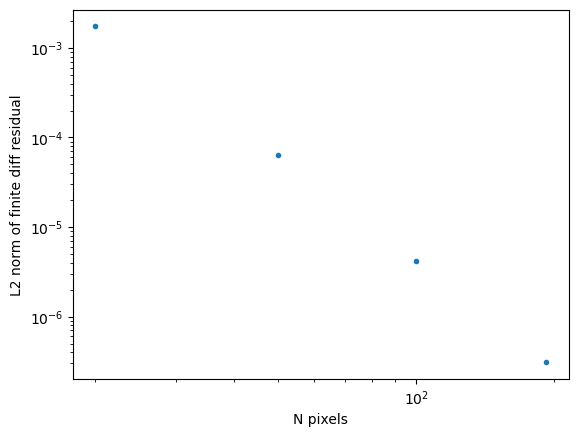

In [9]:
plt.plot(N_PIXELS_ARR, err_val_lst_0, '.')
# plt.plot(N_PIXELS_ARR, check_2_val_lst_0, '.', label='Check 2')
# plt.legend()

# plt.xlim(0, np.max(err_val_lst))
# plt.ylim(0, np.max(err_val_lst))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('N pixels')
plt.ylabel('L2 norm of finite diff residual')
plt.show()

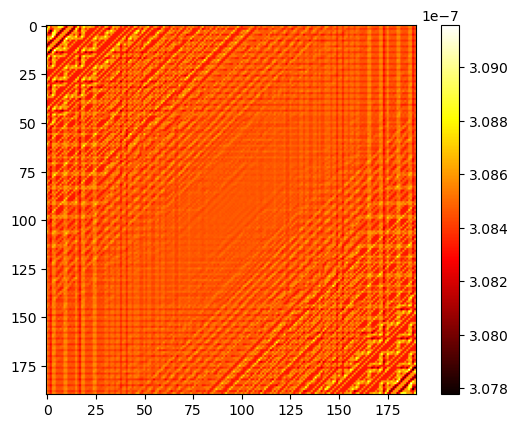

In [11]:
plt.imshow(np.abs(err_pointwise), cmap='hot')
plt.colorbar()
plt.show()

# Test 1: Gaussian bump

In [12]:
SCALE = -5.
def _gaussian(rad: np.ndarray, sigma: float) -> np.ndarray:
    return np.exp(-1 * np.square(rad) / (sigma**2))

err_arr_lst = []
err_val_lst = []
time_lst = []
for i, N_PIXELS in enumerate(N_PIXELS_ARR):
    coords_i = solver_obj[i].domain_points_arr

    nrms_i = np.linalg.norm(coords_i, axis=2)

    scattering_obj = SCALE * _gaussian(nrms_i, 0.1)
    t0 = default_timer()
    soln, u_in, u_s = solver_obj[i].Helmholtz_solve_interior(in_direction, scattering_obj)
    time_lst.append(default_timer() - t0)
    soln = soln[0]
    u_in = u_in[0]
    u_s = u_s[0]
    err_pointwise, rel_l2_err = check_soln_against_finite_differences(soln,
                                         coords_i,
                                         scattering_obj,
                                         solver_obj[i].frequency)
    err_arr_lst.append(err_pointwise)
    err_val_lst.append(rel_l2_err)
    
#     xx = check_2(u_in,
#                 u_s,
#                 solver_obj[i].domain_points_arr,
#                 scattering_obj,
#                 solver_obj[i].frequency)
#     check_2_arr_lst.append(xx)
#     check_2_val_lst.append(np.linalg.norm(xx))
    print("Finished with N_PIXELS=", N_PIXELS)

Finished with N_PIXELS= 20


Finished with N_PIXELS= 50


Finished with N_PIXELS= 100


Finished with N_PIXELS= 192


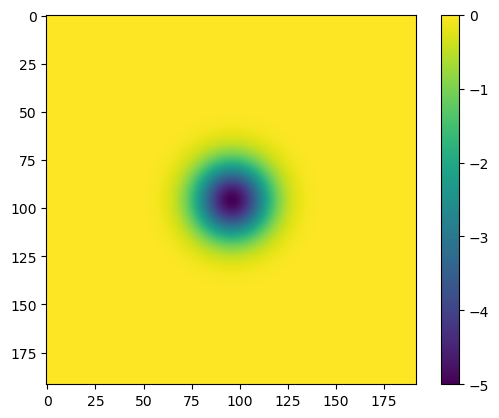

In [13]:
plt.imshow(scattering_obj)
plt.colorbar()
plt.show()

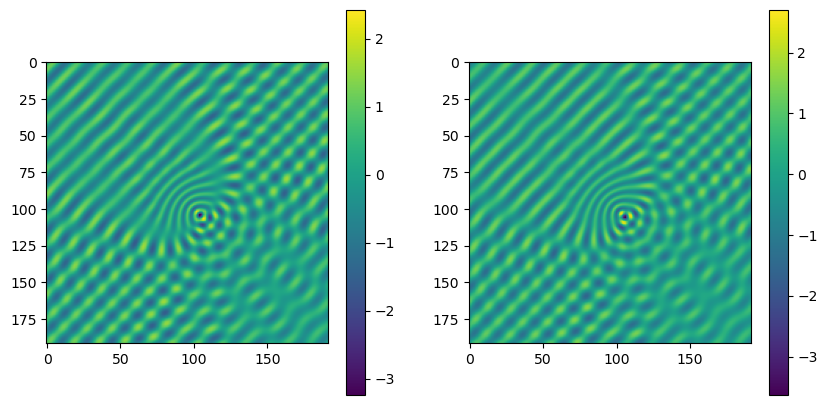

In [14]:
fig, ax = plt.subplots(1,2)
fig.patch.set_facecolor('white')
fig.set_size_inches(10, 5)
im_0 = ax[0].imshow(soln.real)
plt.colorbar(im_0, ax=ax[0])
im_1 = ax[1].imshow(soln.imag)
plt.colorbar(im_1, ax=ax[1])

plt.show()

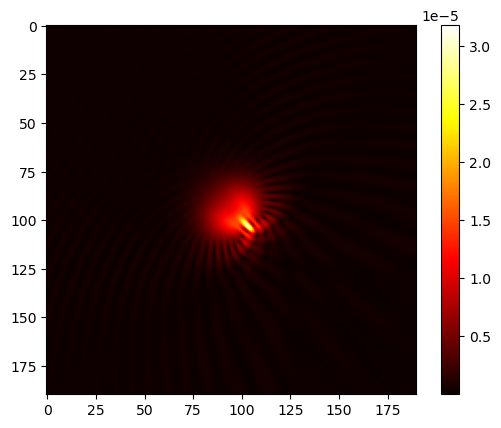

In [15]:
plt.imshow(np.abs(err_pointwise), cmap='hot')
plt.colorbar()
plt.show()

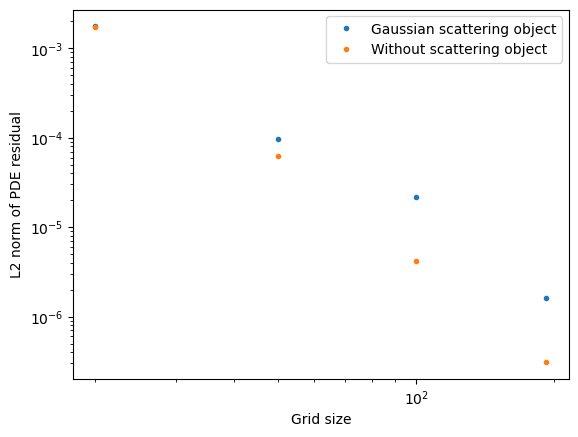

In [16]:
plt.plot(N_PIXELS_ARR, err_val_lst, '.', label='Gaussian scattering object')
plt.plot(N_PIXELS_ARR, err_val_lst_0, '.', label='Without scattering object')
# plt.plot(N_PIXELS_ARR, check_2_val_lst, '.', label='Check 2')
plt.legend()
# plt.xlim(0, np.max(err_val_lst))
# plt.ylim(0, np.max(err_val_lst))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grid size')
plt.ylabel('L2 norm of PDE residual')
plt.show()

# Test 2: Circle

In [17]:

# in_direction = np.pi / 4
err_arr_lst = []
err_val_lst_1 = []
time_lst_1 = []
for i, N_PIXELS in enumerate(N_PIXELS_ARR):
    coords_i = solver_obj[i].domain_points_arr

    nrms_i = np.linalg.norm(coords_i, axis=2)

    scattering_obj = SCALE * (nrms_i < 0.1)
    t0 = default_timer()
    soln, u_in, u_s = solver_obj[i].Helmholtz_solve_interior(in_direction, scattering_obj)
    time_lst_1.append(default_timer() - t0)
    soln = soln[0]
    u_in = u_in[0]
    u_s = u_s[0]
    err_pointwise, rel_l2_err = check_soln_against_finite_differences(soln,
                                         coords_i,
                                         scattering_obj,
                                         solver_obj[i].frequency)
    err_arr_lst.append(err_pointwise)
    err_val_lst_1.append(rel_l2_err)
    print("Finished with N_PIXELS=", N_PIXELS)

Finished with N_PIXELS= 20


Finished with N_PIXELS= 50


Finished with N_PIXELS= 100


Finished with N_PIXELS= 192


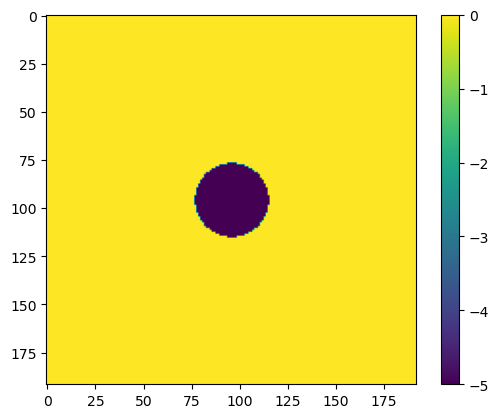

In [18]:
plt.imshow(scattering_obj)
plt.colorbar()
plt.show()

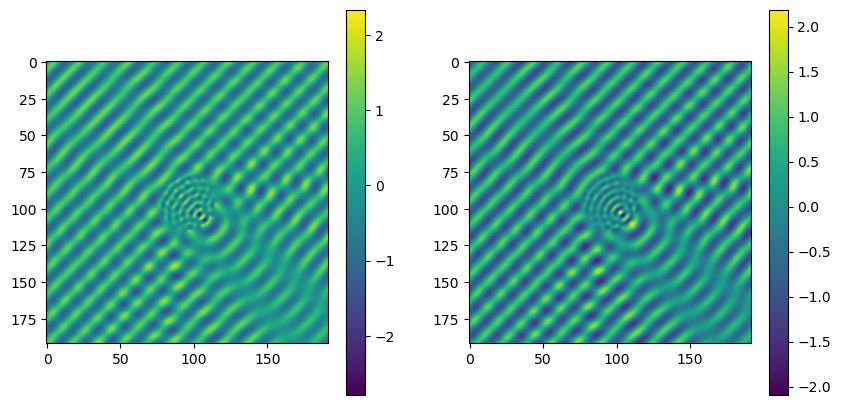

In [19]:
fig, ax = plt.subplots(1,2)
fig.patch.set_facecolor('white')
fig.set_size_inches(10, 5)
im_0 = ax[0].imshow(soln.real)
plt.colorbar(im_0, ax=ax[0])
im_1 = ax[1].imshow(soln.imag)
plt.colorbar(im_1, ax=ax[1])

plt.show()

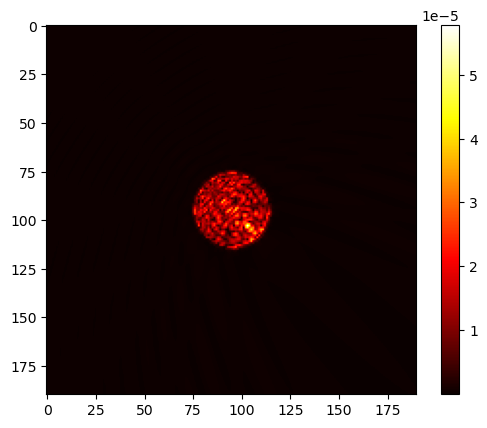

In [21]:
plt.imshow(np.abs(err_pointwise), cmap='hot')
plt.colorbar()
plt.show()

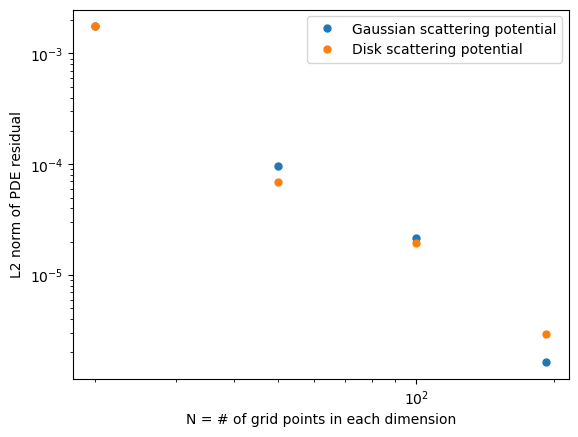

In [22]:
# plt.plot(N_PIXELS_ARR, err_val_lst_0, '.', label='Zero scattering potential')

plt.plot(N_PIXELS_ARR, err_val_lst, '.', markersize=10, label='Gaussian scattering potential')
plt.plot(N_PIXELS_ARR, err_val_lst_1, '.', markersize=10, label='Disk scattering potential')
plt.legend()
# plt.xlim(0, np.max(err_val_lst))
# plt.ylim(0, np.max(err_val_lst))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('N = # of grid points in each dimension')
plt.ylabel('L2 norm of PDE residual')
plt.show()

# Time full exterior solves

In [23]:

def _gaussian(rad: np.ndarray, sigma: float) -> np.ndarray:
    return np.exp(-1 * np.square(rad) / (sigma**2))


time_lst = []

for i, N_PIXELS in enumerate(N_PIXELS_ARR):
    coords_i = solver_obj[i].domain_points_arr

    dirs_i = solver_obj[i].source_dirs
    nrms_i = np.linalg.norm(coords_i, axis=2)

    scattering_obj = SCALE * _gaussian(nrms_i, 0.1)
    t0 = default_timer()
    ext_soln = solver_obj[i].Helmholtz_solve_exterior(source_directions=dirs_i, scattering_obj=scattering_obj)
    time_lst.append(default_timer() - t0)
    print("Finished with N_PIXELS=", N_PIXELS)

Finished with N_PIXELS= 20


Finished with N_PIXELS= 50


Finished with N_PIXELS= 100


OutOfMemoryError: CUDA out of memory. Tried to allocate 5.27 GiB. GPU 0 has a total capacty of 10.75 GiB of which 3.31 GiB is free. Process 1985768 has 648.00 MiB memory in use. Including non-PyTorch memory, this process has 6.81 GiB memory in use. Of the allocated memory 5.70 GiB is allocated by PyTorch, and 908.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [23]:

time_lst_1 = []
out_arrs = []
in_arrs = []
for i, N_PIXELS in enumerate(N_PIXELS_ARR):
    coords_i = solver_obj[i].domain_points_arr
    dirs_i = solver_obj[i].source_dirs

    nrms_i = np.linalg.norm(coords_i, axis=2)
    
    np.random.seed(0)
    scattering_obj = generate_random_scattering_obj(SPATIAL_DOMAIN_MAX, N_PIXELS, SCALE)
    in_arrs.append(scattering_obj)
    t0 = default_timer()
    ext_soln = solver_obj[i].Helmholtz_solve_exterior(source_directions=dirs_i, scattering_obj=scattering_obj)
    time_lst_1.append(default_timer() - t0)
    out_arrs.append(ext_soln)
    print("Finished with N_PIXELS=", N_PIXELS)

Finished with N_PIXELS= 20
Finished with N_PIXELS= 50
Finished with N_PIXELS= 100
Finished with N_PIXELS= 192


Text(0, 0.5, 'Solution time on GPU (seconds)')

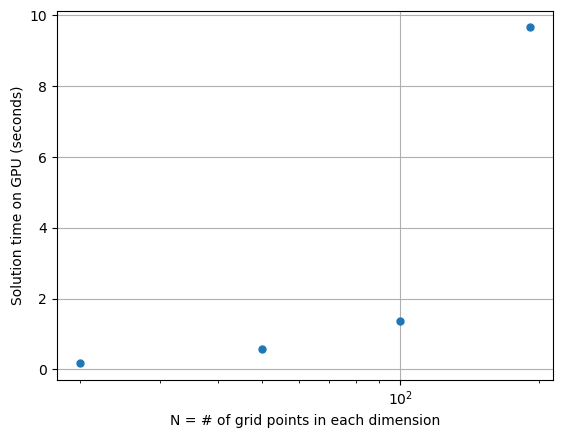

In [42]:
# plt.plot(N_PIXELS_ARR, time_lst, '.', markersize=10, label='Gaussian scattering potential')
plt.plot(N_PIXELS_ARR, time_lst_1, '.', markersize=10, label='Disk scattering potential')
# plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('N = # of grid points in each dimension')
plt.ylabel('Solution time on GPU (seconds)')

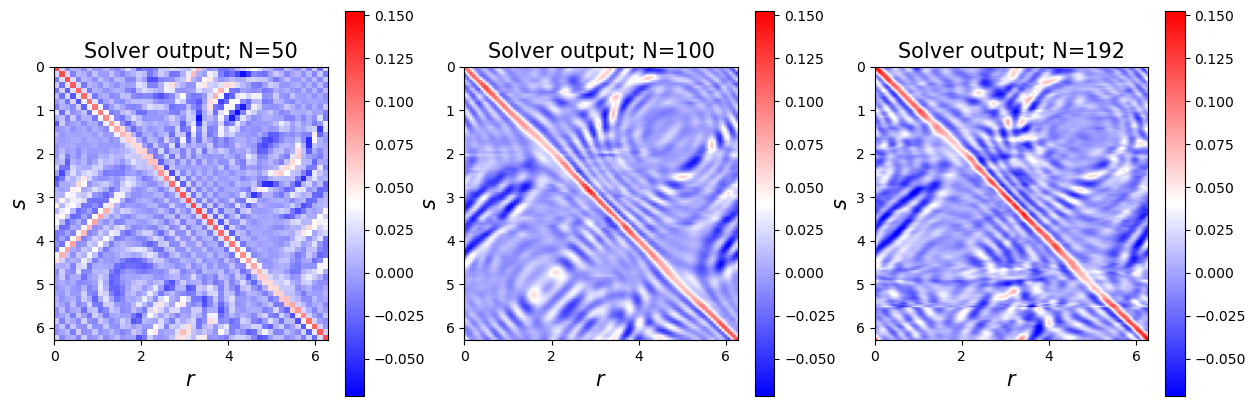

In [39]:
EXTENT = np.array([0, 2 * np.pi, 2 * np.pi, 0])
CMAP='bwr'
SIZE = 15
fig, ax = plt.subplots(1, 3)
fig.patch.set_facecolor('white')
fig.set_size_inches(15, 5)

max_val = max(out_arrs[-1].imag.max(), out_arrs[-2].imag.max(), out_arrs[-3].imag.max())
min_val = max(out_arrs[-1].imag.min(), out_arrs[-2].imag.min(), out_arrs[-3].imag.min())

im_2 = ax[0].imshow(out_arrs[-3].imag, extent=EXTENT, cmap=CMAP)
im_2.set_clim(max_val, min_val)
ax[0].set_xlabel('$r$', size=SIZE)
ax[0].set_ylabel('$s$', size=SIZE)
ax[0].set_title("Solver output; N=50", size=SIZE)
plt.colorbar(im_2, ax=ax[0])

im_1 = ax[1].imshow(out_arrs[-2].imag, extent=EXTENT, cmap=CMAP)
im_1.set_clim(max_val, min_val)
ax[1].set_xlabel('$r$', size=SIZE)
ax[1].set_ylabel('$s$', size=SIZE)
ax[1].set_title("Solver output; N=100", size=SIZE)
plt.colorbar(im_1, ax=ax[1])

im_0 = ax[2].imshow(out_arrs[-1].imag, extent=EXTENT, cmap=CMAP)
ax[2].set_title("Solver output; N=192", size=SIZE)
ax[2].set_xlabel('$r$', size=SIZE)
ax[2].set_ylabel('$s$', size=SIZE)
im_0.set_clim(max_val, min_val)
plt.colorbar(im_0, ax=ax[2])


plt.show()

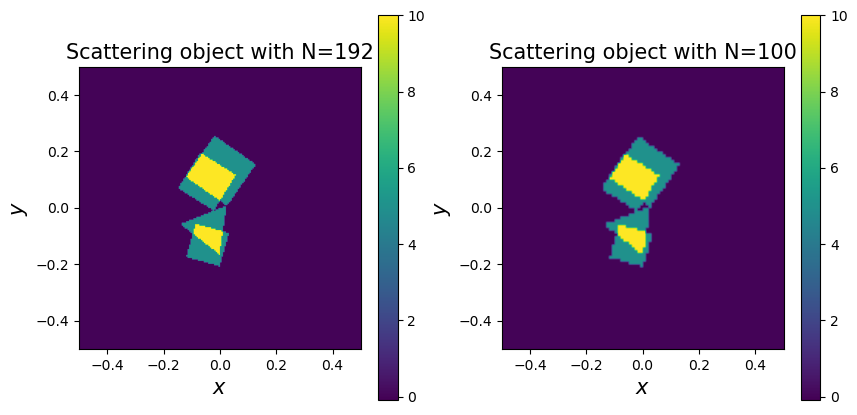

In [36]:
EXTENT = np.array([-0.5, 0.5, -0.5, 0.5])
CMAP='bwr'
SIZE = 15
fig, ax = plt.subplots(1, 2)
fig.patch.set_facecolor('white')
fig.set_size_inches(10, 5)

max_val = 10. #max(out_arrs[-1].imag.max(), out_arrs[-1].imag.max())
min_val = 0. #max(out_arrs[-1].imag.min(), out_arrs[-1].imag.min())


im_0 = ax[0].imshow(in_arrs[-1], extent=EXTENT)
ax[0].set_title("Scattering object with N=192", size=SIZE)
ax[0].set_xlabel('$x$', size=SIZE)
ax[0].set_ylabel('$y$', size=SIZE)
im_0.set_clim(max_val, min_val)
plt.colorbar(im_0, ax=ax[0])
im_1 = ax[1].imshow(in_arrs[-2], extent=EXTENT)
im_1.set_clim(max_val, min_val)
ax[1].set_xlabel('$x$', size=SIZE)
ax[1].set_ylabel('$y$', size=SIZE)
ax[1].set_title("Scattering object with N=100", size=SIZE)
plt.colorbar(im_1, ax=ax[1])

plt.show()

In [24]:
print(err_val_lst)
print(err_val_lst_0)
print(err_val_lst_1)

[0.0058107311578484405, 0.00041107063334747297, 5.2741531956801303e-05, 6.672585385199962e-06]
[0.004440262945455327, 0.00031375829748216783, 4.023564076157041e-05, 5.1000712548191755e-06]
[0.006448339305159342, 0.0005131229705832958, 0.00010129223008080499, 2.7211378692097036e-05]


# Test 2: Test against dense solver

In [16]:
solver_obj_dense = [setup_dense_solver(x, SPATIAL_DOMAIN_MAX, WAVENUMBER, RECIEVER_RADIUS) for x in N_PIXELS_ARR]

KeyboardInterrupt: 

In [20]:
soln_dense, u_in, u_s = solver_obj_dense.single_Helmholtz_solve_interior(in_direction, scattering_obj)

In [ ]:
diffs = soln_dense - soln

In [ ]:
plt.imshow(np.abs(diffs))
plt.colorbar()
plt.show()

In [34]:
x = relative_l2_error(soln_dense, soln)

In [35]:
print(x)

1.2557166355078302e-15


# Scratch space

In [38]:
import numpy as np 
from scipy.special import hankel1
from scipy.integrate import dblquad, quad
import matplotlib.pyplot as plt

In [56]:
h = 1 / 192
k = 16 * 2 * np.pi

In [57]:
MAX = 5

n_grid_points = int(2 * MAX / h)

grid = np.arange(n_grid_points) * h - MAX

In [58]:
print(grid)

[-5.         -4.99479167 -4.98958333 ...  4.984375    4.98958333
  4.99479167]


In [65]:
def _gaussian(rad: np.ndarray, sigma: float) -> np.ndarray:
    return np.exp(-1 * np.square(rad) / (sigma**2))


def _greens_fn(rad: np.ndarray, k: float) -> np.ndarray:
    tmp = hankel1(0, k * rad)

    # cover the singularity with a 0
    i = np.argwhere(rad == 0)
    tmp[i] = 0.0

    return -1j / 4 * tmp


def find_diag_correction(h: float, k: float) -> float:
    """
    1. make a 1D grid with bounds [-5, 5] and spacing h
    2. make f(x) = narrow Gaussian centered at 0
    3. make g(x) = Green's function
    4. Compute int f(x) g(x) on grid defined above via punctured trapezoid rule
      (zero out g(x) at singularity)
    5. Compute int f(x) g(x) on domain defined above with some adaptive integration
      (fron scipy)
    6. Return diff / (h ** 2)
    """
    MAX = 5
    
    SIGMA_VAL = 2 * MAX * h

    # Set up grid
    n_grid_points = int(2 * MAX / h)
    grid = np.arange(n_grid_points) * h - MAX

    # x, y = np.meshgrid(grid, grid)
    # mesh = np.stack((x, y), axis=-1)
    # mesh_radii = np.linalg.norm(mesh, axis=2)
    # assert 0 in mesh_radii

    f_evals = _gaussian(grid, SIGMA_VAL)
    g_evals = _greens_fn(grid, k)

    punctured_trap_val = np.sum(f_evals * g_evals * h)
    print("punctured_trap_val: ", punctured_trap_val)

    def _int_eval_func(x: float) -> float:
        f = _gaussian(x, SIGMA_VAL)
        g = -1j / 4 * hankel1(0, k * x)
        return f + g

    adaptive_int_val, _ = quad(_int_eval_func, -MAX, MAX, complex_func=True, points=(0,), limit=100)
    print("adaptive_int_val: ", adaptive_int_val)
    
    diff = (adaptive_int_val - punctured_trap_val) / (h**2)
    return diff

In [66]:
l = find_diag_correction(h, k)

punctured_trap_val:  (0.0021468458362357717-1.5439038936193583e-16j)
adaptive_int_val:  (0.09219030237043939-4.069146278609659e-18j)


In [67]:
l

(3319.3619816768824+5.541442305023736e-12j)

In [68]:
grid

array([-5.        , -4.99479167, -4.98958333, ...,  4.984375  ,
        4.98958333,  4.99479167])

In [69]:
f = _gaussian(grid, 10 * h)
g = _greens_fn(grid, k)

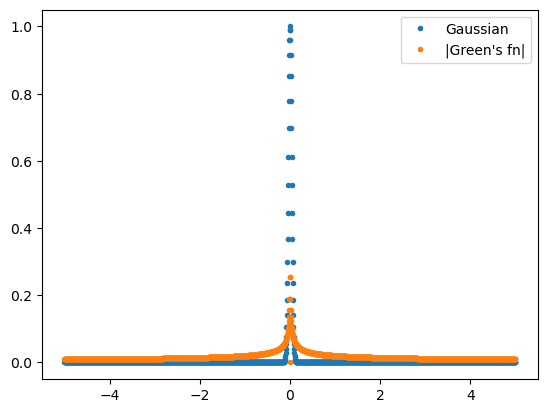

In [70]:
plt.plot(grid, f, '.', label='Gaussian')
plt.plot(grid, np.abs(g), '.', label="|Green's fn|")
plt.legend()
plt.show()